# Clasificación multiclase

## Introduction


In [75]:
# utilizado para la manipulación de directorios y rutas
import os

# Cálculo científico y vectorial para python
import numpy as np

# Libreria para graficos
from matplotlib import pyplot

# Modulo de optimizacion en scipy
from scipy import optimize

# modulo para cargar archivos en formato MATLAB
#from scipy.io import loadmat

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline

import pandas as pd

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
# Cargar datos desde el archivo CSV
data = pd.read_csv('/content/drive/Othercomputers/Mi PC/Semestre 2-2024/SIS420 - INTELIGENCIA ARTIFICIAL I/1erParcial_IA/1erParcial_datasets/20.PCA NN and CNN with Keras/chineseMNIST.csv')

# Verificar las primeras filas del dataframe para entender su estructura
print(data.head())


   pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  pixel_7  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   pixel_8  pixel_9  ...  pixel_4088  pixel_4089  pixel_4090  pixel_4091  \
0        0        0  ...           0           0           0           0   
1        0        0  ...           0           0           0           0   
2        0        0  ...           0           0           0           0   
3        0        0  ...           0           0           0           0   
4        0        0  ...           0           0           0           0   

   pixel_4092  pixel_4093  pixel_4094  pixel_4095  label  character  
0         

In [77]:
print(data.shape)  # Muestra el número de filas y columnas

(15000, 4098)


1.      Inserte atributos que contengan, caracteres(pronunciacion), texto(Tipo_numero), valores booleanos("simetria") relacionados a la temática del dataset elegido.

In [35]:
# Calcular brillo como el promedio de los valores de los píxeles
data['Brillo'] = data.iloc[:, :4096].mean(axis=1)
#Se calcula el promedio de los valores de los píxeles para cada fila (desde la columna 0 hasta la columna 4095).

# Calcular iluminación como el rango de los valores de los píxeles
data['Iluminacion'] = data.iloc[:, :4096].max(axis=1) - data.iloc[:, :4096].min(axis=1)
#Se calcula el rango de los valores de los píxeles para cada fila, que es la diferencia entre el valor máximo y el valor mínimo.

# Mostrar las nuevas columnas
print(data[['Brillo', 'Iluminacion']].head())

     Brillo  Iluminacion
0  3.866943          206
1  2.322510          191
2  4.155029          227
3  3.394287          205
4  3.656006          213


In [36]:
caracteres_unicos = data['character'].unique() # Obtener todos los caracteres únicos de la columna 'character'

lista_caracteres = caracteres_unicos.tolist() # Convertir el resultado a una lista

# Mostrar la lista
print(lista_caracteres)


['九', '十', '百', '千', '万', '亿', '零', '一', '二', '三', '四', '五', '六', '七', '八']


In [37]:
label_unicos = data['label'].unique() # Obtener todos los label únicos de la columna 'label'

lista_label = label_unicos.tolist() # Convertir el resultado a una lista

# Mostrar la lista
print(lista_label)


[9, 10, 100, 1000, 10000, 100000000, 0, 1, 2, 3, 4, 5, 6, 7, 8]


Se separaran los caracteres simétricos de los no simétricos, se utilizara una lista de caracteres simétricos y luego se analizara el dataset.

In [38]:
# Lista de caracteres simétricos
simetricos = ['一', '二', '三', '十', '百', '八']  # Ajusta según tus caracteres simétricos

# Añadir la columna "Simetria" como booleano (1/0) sin reemplazar 'data'
data['Simetria'] = data['character'].apply(lambda x: 1 if x in simetricos else 0)

# Mostrar el DataFrame con la nueva columna
print(data.iloc[:, -7:])

       pixel_4094  pixel_4095  label character    Brillo  Iluminacion  \
0               0           0      9         九  3.866943          206   
1               0           0      9         九  2.322510          191   
2               0           0      9         九  4.155029          227   
3               0           0      9         九  3.394287          205   
4               0           0      9         九  3.656006          213   
...           ...         ...    ...       ...       ...          ...   
14995           0           0      8         八  2.160645          163   
14996           0           0      8         八  1.898926          170   
14997           0           0      8         八  1.854980          154   
14998           0           0      8         八  1.808350          169   
14999           0           0      8         八  1.995850          146   

       Simetria  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...

In [39]:
#Filas específicas (fila n a la n)
print(data[['character', 'Simetria']].iloc[10100:10120])

      character  Simetria
10100         四         0
10101         四         0
10102         四         0
10103         四         0
10104         四         0
10105         四         0
10106         四         0
10107         四         0
10108         四         0
10109         四         0
10110         四         0
10111         四         0
10112         四         0
10113         四         0
10114         四         0
10115         四         0
10116         四         0
10117         四         0
10118         四         0
10119         四         0


In [40]:
# Clasificación de "label" como "básico" o "complejo" basado en la columna 'label'
def clasificar_tipo_numero(label):
    if label < 10:  # Números básicos [9,8,7,6,5,4,3,2,1,0]
        return 'Basico'
    else:  # Números complejos [10, 100, 1000, 10000, 100000000]
        return 'Complejo'

# Añadir la columna "Tipo_numero" usando la columna 'label'
data['Tipo_numero'] = data['label'].apply(clasificar_tipo_numero)

# Mostrar el DataFrame con la nueva columna
print(data[['character', 'label', 'Tipo_numero','Simetria']])
print(data[['character', 'label', 'Tipo_numero','Simetria']].iloc[5000:5010])

      character  label Tipo_numero  Simetria
0             九      9      Basico         0
1             九      9      Basico         0
2             九      9      Basico         0
3             九      9      Basico         0
4             九      9      Basico         0
...         ...    ...         ...       ...
14995         八      8      Basico         1
14996         八      8      Basico         1
14997         八      8      Basico         1
14998         八      8      Basico         1
14999         八      8      Basico         1

[15000 rows x 4 columns]
     character      label Tipo_numero  Simetria
5000         亿  100000000    Complejo         0
5001         亿  100000000    Complejo         0
5002         亿  100000000    Complejo         0
5003         亿  100000000    Complejo         0
5004         亿  100000000    Complejo         0
5005         亿  100000000    Complejo         0
5006         亿  100000000    Complejo         0
5007         亿  100000000    Complejo         0
50

In [41]:
# Mapa de pronunciaciones
pronunciacion = {
    '零': 'líng',  # 0
    '一': 'yī',    # 1
    '二': 'èr',    # 2
    '三': 'sān',   # 3
    '四': 'sì',    # 4
    '五': 'wǔ',    # 5
    '六': 'liù',   # 6
    '七': 'qī',    # 7
    '八': 'bā',    # 8
    '九': 'jiǔ',   # 9
    '十': 'shí',   # 10
    '百': 'bǎi',   # 100
    '千': 'qiān',  # 1000
    '万': 'wàn',   # 10,000
    '亿': 'yì'     # 100,000,000
}

# Crear una nueva columna de pronunciación
data['pronunciacion'] = data['character'].map(pronunciacion)

# Mostrar el DataFrame con la nueva columna
print(data[['character', 'label', 'Tipo_numero','Simetria', "pronunciacion"]])


      character  label Tipo_numero  Simetria pronunciacion
0             九      9      Basico         0           jiǔ
1             九      9      Basico         0           jiǔ
2             九      9      Basico         0           jiǔ
3             九      9      Basico         0           jiǔ
4             九      9      Basico         0           jiǔ
...         ...    ...         ...       ...           ...
14995         八      8      Basico         1            bā
14996         八      8      Basico         1            bā
14997         八      8      Basico         1            bā
14998         八      8      Basico         1            bā
14999         八      8      Basico         1            bā

[15000 rows x 5 columns]


In [42]:
print(data.iloc[:, -7:])

       label character    Brillo  Iluminacion  Simetria Tipo_numero  \
0          9         九  3.866943          206         0      Basico   
1          9         九  2.322510          191         0      Basico   
2          9         九  4.155029          227         0      Basico   
3          9         九  3.394287          205         0      Basico   
4          9         九  3.656006          213         0      Basico   
...      ...       ...       ...          ...       ...         ...   
14995      8         八  2.160645          163         1      Basico   
14996      8         八  1.898926          170         1      Basico   
14997      8         八  1.854980          154         1      Basico   
14998      8         八  1.808350          169         1      Basico   
14999      8         八  1.995850          146         1      Basico   

      pronunciacion  
0               jiǔ  
1               jiǔ  
2               jiǔ  
3               jiǔ  
4               jiǔ  
...            

2. Duplique los ejemplos del dataset considerando rangos y criterios que garanticen la consistencia del dataset.

In [45]:
# Duplicar 5000 ejemplos de forma aleatoria
num_duplicados = 5000
indices_duplicados = np.random.choice(data.index, size=num_duplicados, replace=True)

# Crear un nuevo DataFrame con los duplicados y resetear el índice
duplicados = data.loc[indices_duplicados].reset_index(drop=True)

# Guardar los datos duplicados en una variable aparte
datos_duplicados = duplicados.copy()

# Modificaciones en los duplicados: ejemplo de cómo modificar la columna 'label'
# Restar 1 a los que son menores o igual a 10 en la columna 'label'
duplicados.loc[(duplicados['label'] < 10) & (duplicados['label'] > 0), 'label'] -= 1

# Asegurarse de que 'label' es de tipo string para agregar '0'
duplicados['label'] = duplicados['label'].astype(str)

# Agregar un 0 a las filas con label igual a '1', '10' y '100'
duplicados.loc[duplicados['label'].isin(['1', '10', '100']), 'label'] += '0'

# Intercambiar cantidades de 0 entre 10000 y 100000000
duplicados.loc[duplicados['label'] == '10000', 'label'] = '100000000'
duplicados.loc[duplicados['label'] == '100000000', 'label'] = '10000'

# Convertir la columna 'label' de vuelta a int
duplicados['label'] = duplicados['label'].astype(int)

# --- Mantener coherencia en la columna 'character' en los duplicados ---

# Mapa entre label y character
label_to_character = {
    0: '零', 1: '一', 2: '二', 3: '三', 4: '四',
    5: '五', 6: '六', 7: '七', 8: '八', 9: '九',
    10: '十', 100: '百', 1000: '千', 10000: '万', 100000000: '亿'
}

# Recalcular la columna 'character' en base al valor de 'label'
duplicados['character'] = duplicados['label'].map(label_to_character)

# --- Mantener coherencia en las demás columnas ---

# Recalcular la columna "Simetria" en función de la columna 'character'
simetricos = ['一', '二', '三', '十', '百', '八']  # Ajusta según tus caracteres simétricos
duplicados['Simetria'] = duplicados['character'].apply(lambda x: 1 if x in simetricos else 0)

# Recalcular la columna "Tipo_numero" en función de la columna 'label'
def clasificar_tipo_numero(label):
    if label < 10:  # Números básicos [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
        return 'Basico'
    else:  # Números complejos [10, 100, 1000, 10000, 100000000]
        return 'Complejo'
duplicados['Tipo_numero'] = duplicados['label'].apply(clasificar_tipo_numero)

# Recalcular la columna "pronunciacion" en función de la columna 'character'
pronunciacion = {
    '零': 'líng', '一': 'yī', '二': 'èr', '三': 'sān', '四': 'sì',
    '五': 'wǔ', '六': 'liù', '七': 'qī', '八': 'bā', '九': 'jiǔ',
    '十': 'shí', '百': 'bǎi', '千': 'qiān', '万': 'wàn', '亿': 'yì'
}
duplicados['pronunciacion'] = duplicados['character'].map(pronunciacion)

# Concatenar los originales con los duplicados para obtener el DataFrame ampliado
data_ampliado = pd.concat([data, duplicados], ignore_index=True)

# Mostrar los datos duplicados con las columnas coherentes
print(duplicados[['character', 'label', 'Tipo_numero', 'Simetria', 'pronunciacion']])



     character  label Tipo_numero  Simetria pronunciacion
0            万  10000    Complejo         0           wàn
1            零      0      Basico         0          líng
2            千   1000    Complejo         0          qiān
3            零      0      Basico         0          líng
4            千   1000    Complejo         0          qiān
...        ...    ...         ...       ...           ...
4995         零      0      Basico         0          líng
4996         百    100    Complejo         1           bǎi
4997         万  10000    Complejo         0           wàn
4998         五      5      Basico         0            wǔ
4999         万  10000    Complejo         0           wàn

[5000 rows x 5 columns]


In [46]:
print(data_ampliado.iloc[:, -7:])

       label character    Brillo  Iluminacion  Simetria Tipo_numero  \
0          9         九  3.866943          206         0      Basico   
1          9         九  2.322510          191         0      Basico   
2          9         九  4.155029          227         0      Basico   
3          9         九  3.394287          205         0      Basico   
4          9         九  3.656006          213         0      Basico   
...      ...       ...       ...          ...       ...         ...   
19995      0         零  0.547852          136         0      Basico   
19996    100         百  1.325439          173         1    Complejo   
19997  10000         万  2.980469          165         0    Complejo   
19998      5         五  2.027100          159         0      Basico   
19999  10000         万  1.516357          178         0    Complejo   

      pronunciacion  
0               jiǔ  
1               jiǔ  
2               jiǔ  
3               jiǔ  
4               jiǔ  
...            

In [29]:
print(data_ampliado.iloc[:, -7:].iloc[15000:15020])

       label character    Brillo  Iluminacion  Simetria Tipo_numero  \
15000      5         六  1.413818          145         0      Basico   
15001   1000         千  1.906250          213         0    Complejo   
15002     10         二  2.060547          178         1      Basico   
15003      4         五  3.137451          216         0      Basico   
15004     10         二  1.437012          155         1      Basico   
15005      8         九  2.133301          148         0      Basico   
15006     10         二  0.993408          133         1      Basico   
15007   1000         千  2.545654          235         0    Complejo   
15008      4         五  2.910645          194         0      Basico   
15009      0         一  0.520508          165         1      Basico   
15010    100         十  1.536865          178         1    Complejo   
15011    100         十  1.235107          176         1    Complejo   
15012      3         四  2.293213          159         0      Basico   
15013 

Convertimos todas las columnas a valores numericos

In [47]:
# Verificar los valores únicos en 'Tipo_numero'
print(data_ampliado['Tipo_numero'].unique())

['Basico' 'Complejo']


In [48]:
# Convertir 'Tipo_numero' a valores numéricos (1 para 'B', 0 para 'C')
data_ampliado['Tipo_numero'] = data_ampliado['Tipo_numero'].map({'Basico': 1, 'Complejo': 0})

# Convertir la pronunciación a su longitud (cantidad de letras)
data_ampliado['pronunciacion'] = data_ampliado['pronunciacion'].map(lambda x: len(x) if isinstance(x, str) else x)

# Convertir la columna 'character' a su valor numérico correspondiente
data_ampliado['character'] = data_ampliado['character'].map({
    '零': 0, '一': 1, '二': 2, '三': 3, '四': 4, '五': 5, '六': 6,
    '七': 7, '八': 8, '九': 9, '十': 10, '百': 100, '千': 1000,
    '万': 10000, '亿': 100000000
})

# Comprobar el resultado
print(data_ampliado[['Tipo_numero', 'pronunciacion', 'character']].head())


   Tipo_numero  pronunciacion  character
0            1              3          9
1            1              3          9
2            1              3          9
3            1              3          9
4            1              3          9


In [49]:
print(data_ampliado.iloc[:, -7:])

       label  character    Brillo  Iluminacion  Simetria  Tipo_numero  \
0          9          9  3.866943          206         0            1   
1          9          9  2.322510          191         0            1   
2          9          9  4.155029          227         0            1   
3          9          9  3.394287          205         0            1   
4          9          9  3.656006          213         0            1   
...      ...        ...       ...          ...       ...          ...   
19995      0          0  0.547852          136         0            1   
19996    100        100  1.325439          173         1            0   
19997  10000      10000  2.980469          165         0            0   
19998      5          5  2.027100          159         0            1   
19999  10000      10000  1.516357          178         0            0   

       pronunciacion  
0                  3  
1                  3  
2                  3  
3                  3  
4       

In [50]:
p_unicos = data_ampliado['pronunciacion'].unique() # Obtener todos los caracteres únicos de la columna 'pronunciacion'

lista_pronunciacion = p_unicos.tolist() # Convertir el resultado a una lista

# Mostrar la lista
print(lista_pronunciacion)

[3, 4, 2]


3.      Crear una grafica representativa de los datos del dataset inicial y otra con los datos del dataset sintético generado.

Dataset Original

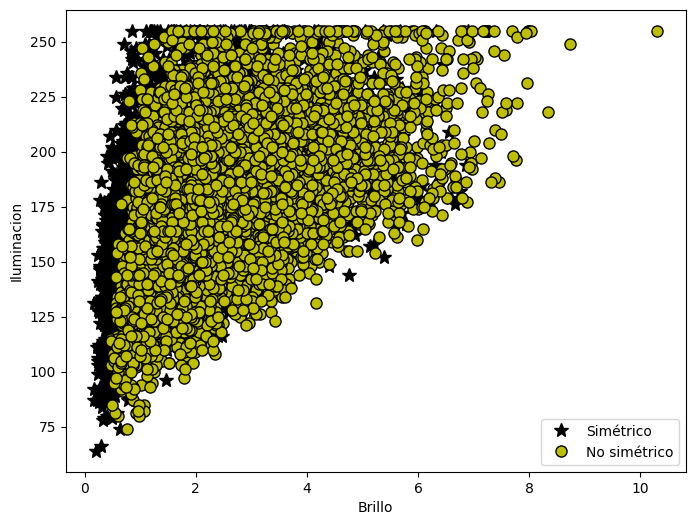

In [67]:
# Asignamos los valores de Brillo e Iluminacion a X
X = data[['Brillo', 'Iluminacion']].values

# Asignamos la columna 'Simetria' como y
y = data['Simetria'].values

def plotData(X, y):
    # Crea una nueva figura
    fig = pyplot.figure(figsize=(8, 6))

    # Encuentra los índices de los ejemplos positivos y negativos
    pos = y == 1
    neg = y == 0

    # Grafica los ejemplos
    pyplot.plot(X[pos, 0], X[pos, 1], 'k*', lw=2, ms=10, label='Simétrico')
    pyplot.plot(X[neg, 0], X[neg, 1], 'ko', mfc='y', ms=8, mec='k', mew=1, label='No simétrico')

    # Adiciona etiquetas a los ejes
    pyplot.xlabel('Brillo')
    pyplot.ylabel('Iluminacion')
    pyplot.legend()

# Llamada a la función para graficar los datos
plotData(X, y)

# Mostrar el gráfico
pyplot.show()


In [68]:
print(data.head())

   pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  pixel_7  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   pixel_8  pixel_9  ...  pixel_4093  pixel_4094  pixel_4095  label  \
0        0        0  ...           0           0           0      9   
1        0        0  ...           0           0           0      9   
2        0        0  ...           0           0           0      9   
3        0        0  ...           0           0           0      9   
4        0        0  ...           0           0           0      9   

   character    Brillo  Iluminacion  Simetria  Tipo_numero  pronunciacion  
0          九  3.866943          20

Dataset SINTETICO

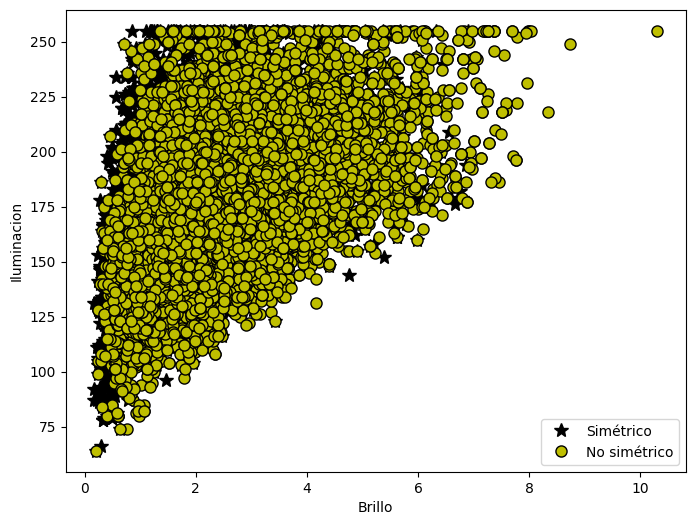

In [65]:
# Asignamos los valores de Brillo e Iluminacion a X
X = data_ampliado[['Brillo', 'Iluminacion']].values

# Asignamos la columna 'Simetria' como y
y = data_ampliado['Simetria'].values

def plotData(X, y):
    # Crea una nueva figura
    fig = pyplot.figure(figsize=(8, 6))

    # Encuentra los índices de los ejemplos positivos y negativos
    pos = y == 1
    neg = y == 0

    # Grafica los ejemplos
    pyplot.plot(X[pos, 0], X[pos, 1], 'k*', lw=2, ms=10, label='Simétrico')
    pyplot.plot(X[neg, 0], X[neg, 1], 'ko', mfc='y', ms=8, mec='k', mew=1, label='No simétrico')

    # Adiciona etiquetas a los ejes
    pyplot.xlabel('Brillo')
    pyplot.ylabel('Iluminacion')
    pyplot.legend()

# Llamada a la función para graficar los datos
plotData(X, y)

# Mostrar el gráfico
pyplot.show()


In [69]:
print(data_am.shape)

   pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  pixel_7  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   pixel_8  pixel_9  ...  pixel_4093  pixel_4094  pixel_4095  label  \
0        0        0  ...           0           0           0      9   
1        0        0  ...           0           0           0      9   
2        0        0  ...           0           0           0      9   
3        0        0  ...           0           0           0      9   
4        0        0  ...           0           0           0      9   

   character    Brillo  Iluminacion  Simetria  Tipo_numero  pronunciacion  
0          9  3.866943          20

In [ ]:
# Asignamos los valores de Brillo e Iluminacion a X
X = data[['Brillo', 'Iluminacion']].values

# Asignamos la columna 'Simetria' como y
y = data['Simetria'].values

def plotData(X, y):
    # Crea una nueva figura
    fig = pyplot.figure(figsize=(8, 6))

    # Encuentra los índices de los ejemplos positivos y negativos
    pos = y == 1
    neg = y == 0

    # Grafica los ejemplos
    pyplot.plot(X[pos, 0], X[pos, 1], 'k*', lw=2, ms=10, label='Simétrico')
    pyplot.plot(X[neg, 0], X[neg, 1], 'ko', mfc='y', ms=8, mec='k', mew=1, label='No simétrico')

    # Adiciona etiquetas a los ejes
    pyplot.xlabel('Brillo')
    pyplot.ylabel('Iluminacion')
    pyplot.legend()

# Llamada a la función para graficar los datos
plotData(X, y)

# Mostrar el gráfico
pyplot.show()


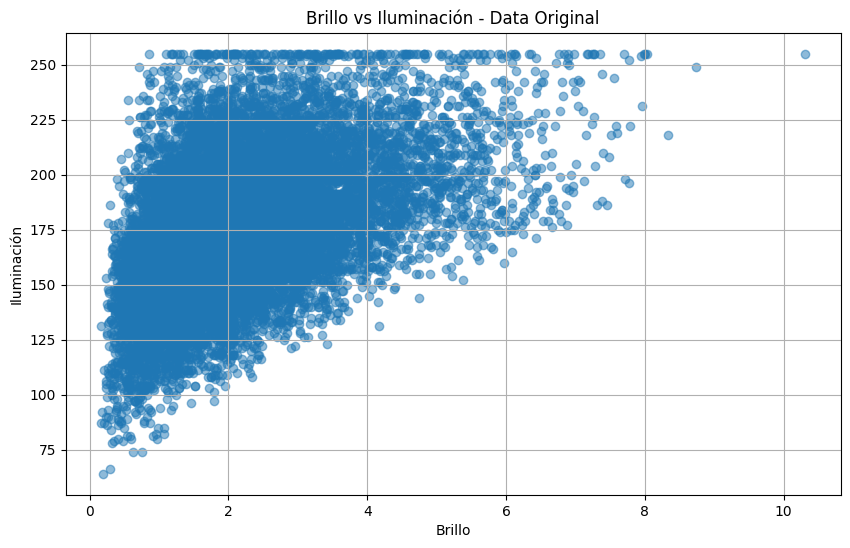

In [55]:
# Graficar el DataFrame original
pyplot.figure(figsize=(10, 6))
pyplot.scatter(data['Brillo'], data['Iluminacion'], alpha=0.5)
pyplot.title('Brillo vs Iluminación - Data Original')
pyplot.xlabel('Brillo')
pyplot.ylabel('Iluminación')
pyplot.grid()
pyplot.show()


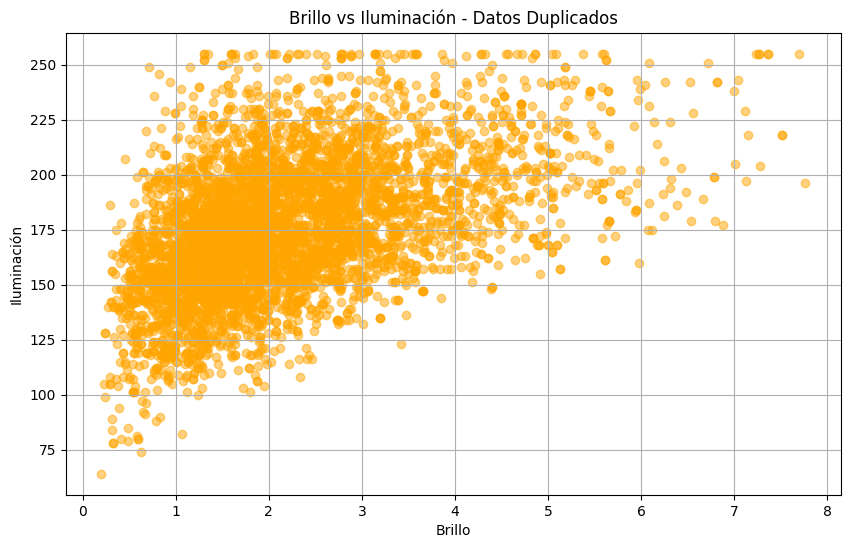

In [57]:
# Graficar el DataFrame de duplicados
pyplot.figure(figsize=(10, 6))
pyplot.scatter(datos_duplicados['Brillo'], datos_duplicados['Iluminacion'], alpha=0.5, color='orange')
pyplot.title('Brillo vs Iluminación - Datos Duplicados')
pyplot.xlabel('Brillo')
pyplot.ylabel('Iluminación')
pyplot.grid()
pyplot.show()


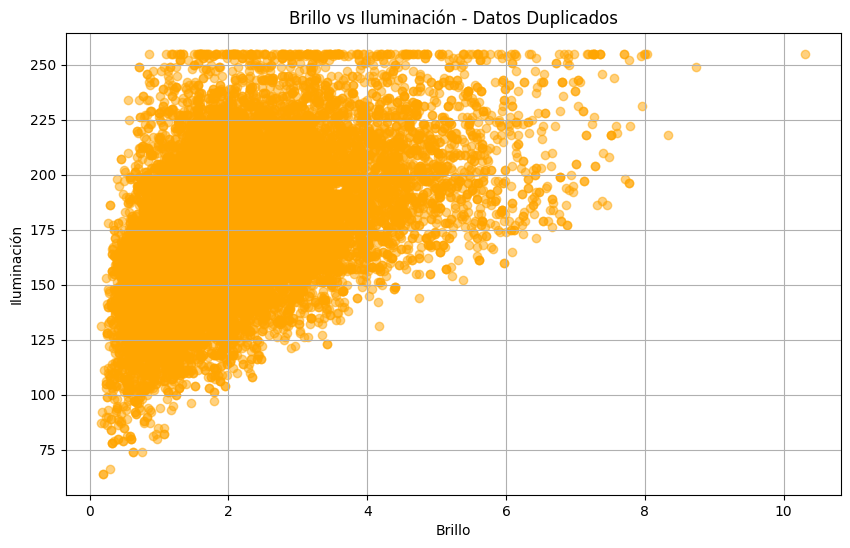

In [60]:
# Graficar el DataFrame de duplicados
pyplot.figure(figsize=(10, 6))
pyplot.scatter(data_ampliado['Brillo'], data_ampliado['Iluminacion'], alpha=0.5, color='orange')
pyplot.title('Brillo vs Iluminación - Datos Duplicados')
pyplot.xlabel('Brillo')
pyplot.ylabel('Iluminación')
pyplot.grid()
pyplot.show()

3.      Crear una grafica representativa de los datos del dataset inicial y otra con los datos del dataset sintético generado.

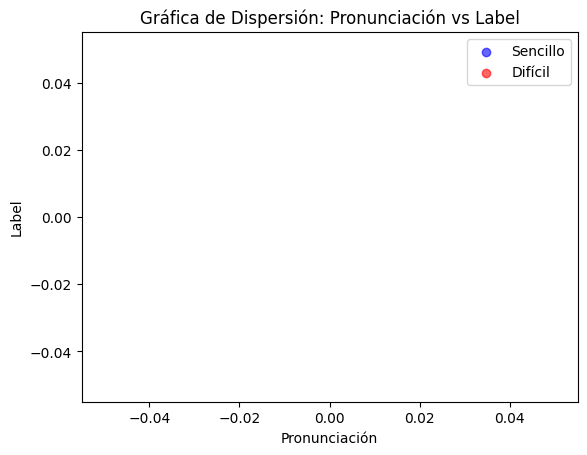

In [267]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Supongamos que 'data_ampliado' es tu DataFrame con los datos

# Convertir 'Tipo_numero' a valores numéricos: 'B' = 0 (sencillo), 'C' = 1 (difícil)
data_ampliado['Tipo_numero'] = data_ampliado['Tipo_numero'].map({'B': 0, 'C': 1})

# Extraer las columnas necesarias
X1 = data_ampliado['pronunciacion'].astype(float).values  # Pronunciación como variable numérica
X2 = data_ampliado['label'].astype(float).values  # Label como variable numérica
y = data_ampliado['Tipo_numero'].values  # Clasificación

# Crear un array X combinando las dos variables
X = np.column_stack((X1, X2))

def plotData(X, y):
    # Crea una nueva figura
    plt.figure()

    # Encuentra los índices de ejemplos sencillos y difíciles
    sencillo = y == 0  # 'B' o 0
    complicado = y == 1  # 'C' o 1

    # Grafica los ejemplos
    plt.scatter(X[sencillo, 0], X[sencillo, 1], color='blue', label='Sencillo', alpha=0.6)
    plt.scatter(X[complicado, 0], X[complicado, 1], color='red', label='Difícil', alpha=0.6)

# Llama a la función para graficar
plotData(X, y)

# Añade etiquetas para los ejes
plt.xlabel('Pronunciación')
plt.ylabel('Label')
plt.legend()
plt.title('Gráfica de Dispersión: Pronunciación vs Label')
plt.show()


## 1 Clasificación multiclase

In [16]:
# Cargar datos desde el archivo CSV
data = pd.read_csv('/content/drive/Othercomputers/Mi PC/Semestre 2-2024/SIS420 - INTELIGENCIA ARTIFICIAL I/1erParcial_IA/1erParcial_datasets/20.PCA NN and CNN with Keras/chineseMNIST.csv')

# Verificar las primeras filas del dataframe para entender su estructura
print(data.head())

# Extraer características y etiquetas
# Las últimas dos columnas son 'label' y 'character'
X = data.iloc[:, :-2].values  # Todas las columnas excepto las dos últimas
y = data['label'].values      # Columna de etiquetas (última columna)

# Establecer el dígito cero en 0, en lugar del 10 asignado a este conjunto de datos
y[y == 10] = 0

# Obtener el número de muestras
m = y.size

# Confirmar el tamaño de las matrices
print("Tamaño de X:", X.shape)
print("Tamaño de y:", y.shape)
print("Número de muestras (m):", m)


   pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  pixel_7  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   pixel_8  pixel_9  ...  pixel_4088  pixel_4089  pixel_4090  pixel_4091  \
0        0        0  ...           0           0           0           0   
1        0        0  ...           0           0           0           0   
2        0        0  ...           0           0           0           0   
3        0        0  ...           0           0           0           0   
4        0        0  ...           0           0           0           0   

   pixel_4092  pixel_4093  pixel_4094  pixel_4095  label  character  
0         

In [17]:
print(X)
print(y)
print(X.shape)
print(y.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[9 9 9 ... 8 8 8]
(15000, 4096)
(15000,)


### 1.2 Visualización de los datos


In [5]:
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Muestra datos 2D almacenados en X en una cuadrícula apropiada.
    """
    # Calcula filas, columnas
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promocionar a una matriz bidimensional
    else:
        raise IndexError('La entrada X debe ser 1 o 2 dimensinal.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Calcula el numero de elementos a mostrar
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')

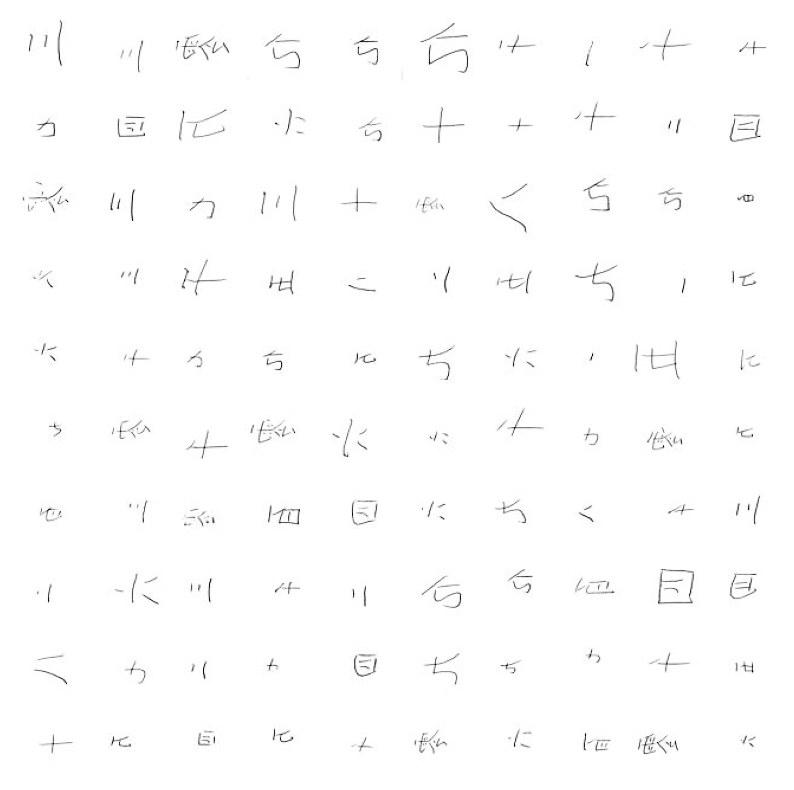

In [6]:
# Selecciona aleatoriamente 100 puntos de datos para mostrar
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

displayData(sel)

2.      Duplique los ejemplos del dataset considerando rangos y criterios que garanticen la consistencia del dataset.

In [21]:
print(data.shape)  # Muestra el número de filas y columnas

(19, 2)


In [ ]:
from skimage.transform import rotate

# Función para duplicar ejemplos con transformaciones
def duplicate_examples(X, y, characters, num_duplicates=1):
    X_duplicated = []
    y_duplicated = []
    characters_duplicated = []

    # Crear duplicados de cada ejemplo con transformaciones
    for i in range(len(X)):
        image = X[i].reshape(64, 64)  # Suponiendo imágenes de 64x64 píxeles

        for _ in range(num_duplicates):
            # Aplicar rotaciones aleatorias
            angle = np.random.uniform(-30, 30)  # Rotación entre -30 y 30 grados
            rotated_image = rotate(image, angle, mode='reflect')

            # Aplanar la imagen rotada y agregar al nuevo dataset
            X_duplicated.append(rotated_image.flatten())
            y_duplicated.append(y[i])
            characters_duplicated.append(characters[i])

    return np.array(X_duplicated), np.array(y_duplicated), np.array(characters_duplicated)

# Duplicar ejemplos
num_duplicates = 2  # Número de duplicados por imagen
X_duplicated, y_duplicated, characters_duplicated = duplicate_examples(X, y, characters, num_duplicates)

# Crear un nuevo DataFrame con los datos duplicados
data_duplicated = pd.DataFrame(X_duplicated)
data_duplicated['label'] = y_duplicated
data_duplicated['character'] = characters_duplicated

# Guardar el DataFrame modificado
data_duplicated.to_csv('/content/drive/Othercomputers/Mi PC/Semestre 2-2024/SIS420 - INTELIGENCIA ARTIFICIAL I/1erParcial_IA/1erParcial_datasets/20.PCA NN and CNN with Keras/chineseMNIST_duplicated.csv', index=False)


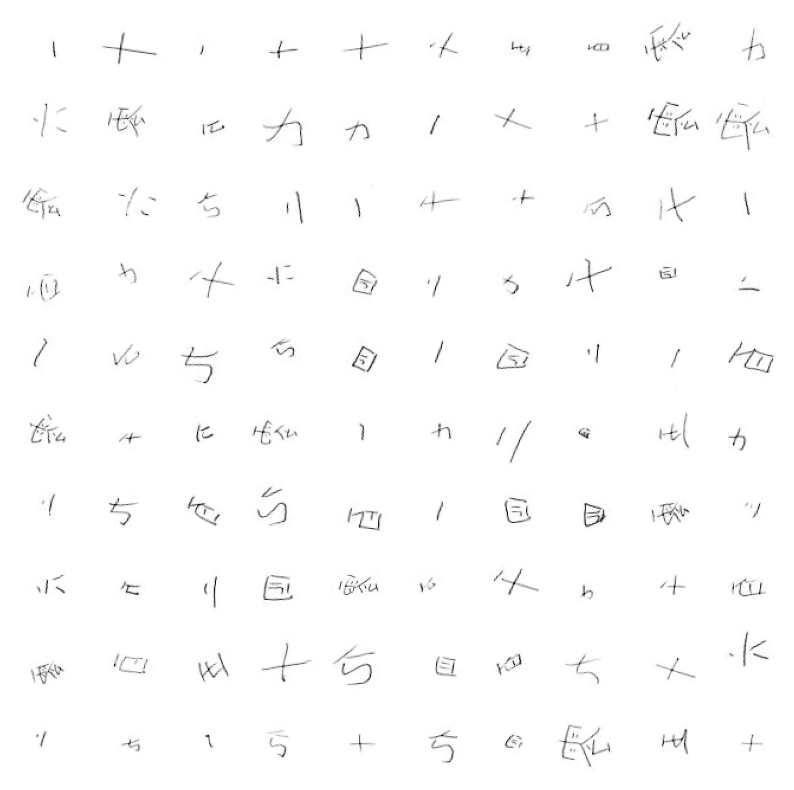

In [ ]:
import matplotlib.pyplot as plt
from skimage.transform import rotate

# Seleccionar aleatoriamente 100 puntos de datos duplicados para mostrar
rand_indices_duplicated = np.random.choice(len(X_duplicated), 100, replace=False)
sel_duplicated = X_duplicated[rand_indices_duplicated, :]

# Función para visualizar datos
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Muestra datos 2D almacenados en X en una cuadrícula apropiada.
    """
    # Calcula filas, columnas
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promocionar a una matriz bidimensional
    else:
        raise IndexError('La entrada X debe ser 1 o 2 dimensiones.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Calcula el número de elementos a mostrar
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = plt.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')

# Visualizar los datos duplicados
displayData(sel_duplicated, example_width=64)  # Ajusta example_width si el tamaño de la imagen es diferente


3.      Crear una grafica representativa de los datos del dataset inicial y otra con los datos del dataset sintético generado.

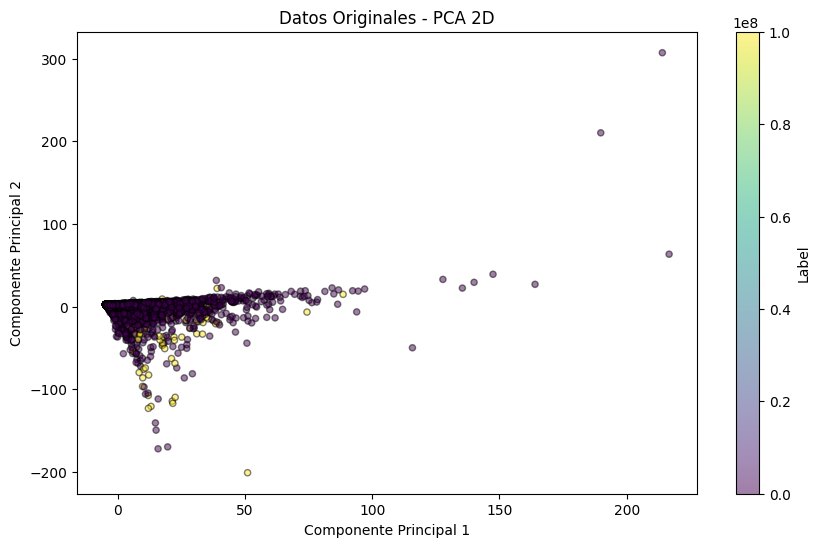

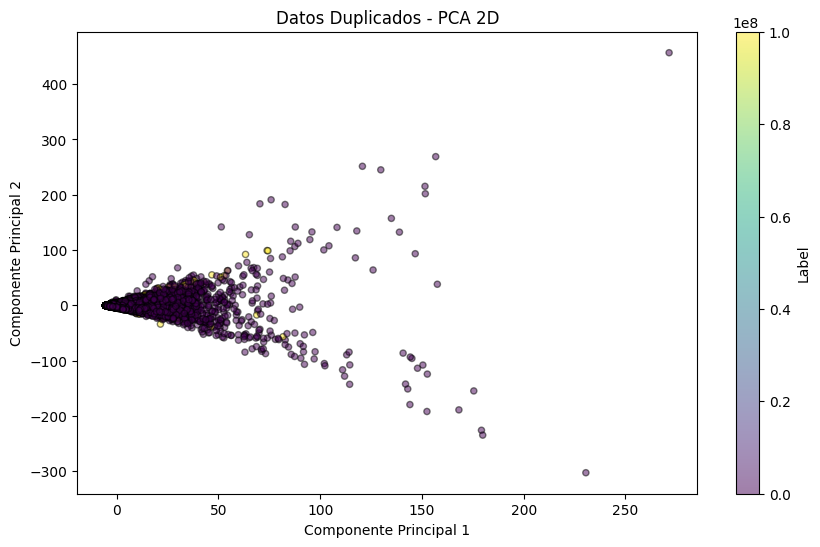

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from skimage.transform import rotate

# Reducir la dimensionalidad a 2D
def reduce_dimensionality(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    return X_pca

# Obtener datos 2D
X_pca_original = reduce_dimensionality(X)
X_pca_duplicated = reduce_dimensionality(X_duplicated)

# Crear gráficos de dispersión
def plot_scatter(X_pca, y, title):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.5, edgecolor='k', s=20)
    plt.colorbar(scatter, label='Label')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.title(title)
    plt.show()

# Graficar datos originales
plot_scatter(X_pca_original, y, 'Datos Originales - PCA 2D')

# Graficar datos duplicados
plot_scatter(X_pca_duplicated, y_duplicated, 'Datos Duplicados - PCA 2D')

====================  Fin del codigo con el Dataset PCA NN and CNN with Keras =======================

### 1.3 Vectorización de regresión logística



In [ ]:
# valores de prueba para los parámetros theta
theta_t = np.array([-2, -1, 1, 2], dtype=float)

# valores de prueba para las entradas
X_t = np.concatenate([np.ones((5, 1)), np.arange(1, 16).reshape(5, 3, order='F')/10.0], axis=1)
print(X_t)
# valores de testeo para las etiquetas
y_t = np.array([1, 0, 1, 0, 1])

# valores de testeo para el parametro de regularizacion
lambda_t = 3

[[1.  0.1 0.6 1.1]
 [1.  0.2 0.7 1.2]
 [1.  0.3 0.8 1.3]
 [1.  0.4 0.9 1.4]
 [1.  0.5 1.  1.5]]


<a id="section1"></a>
#### 1.3.1 Vectorización de la funcion de costo


In [ ]:
def sigmoid(z):
    """
    Calcula la sigmoide de z.
    """
    return 1.0 / (1.0 + np.exp(-z))

In [ ]:
def lrCostFunction(theta, X, y, lambda_):
    """
    Calcula el costo de usar theta como parámetro para la regresión logística regularizada y
    el gradiente del costo w.r.t. a los parámetros.

    Parametros
    ----------
    theta : array_like
        Parametro theta de la regresion logistica. Vector de la forma(shape) (n, ). n es el numero de caracteristicas
        incluida la intercepcion

    X : array_like
        Dataset con la forma(shape) (m x n). m es el numero de ejemplos, y n es el numero de
        caracteristicas (incluida la intercepcion).

    y : array_like
        El conjunto de etiquetas. Un vector con la forma (shape) (m, ). m es el numero de ejemplos

    lambda_ : float
        Parametro de regularización.

    Devuelve
    -------
    J : float
        El valor calculado para la funcion de costo regularizada.

    grad : array_like
        Un vector de la forma (shape) (n, ) que es el gradiente de la
        función de costo con respecto a theta, en los valores actuales de theta..
    """
    # Inicializa algunos valores utiles
    m = y.size

    # convierte las etiquetas a valores enteros si son boleanos
    if y.dtype == bool:
        y = y.astype(int)

    J = 0
    grad = np.zeros(theta.shape)

    h = sigmoid(X.dot(theta.T))

    temp = theta
    temp[0] = 0

    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))

    grad = (1 / m) * (h - y).dot(X)
    grad = grad + (lambda_ / m) * temp

    return J, grad

#### 1.3.3 Vectorización regularizada de la regresión logística


In [ ]:
J, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t)

print('Costo         : {:.6f}'.format(J))
print('Costo esperadot: 2.534819')
print('-----------------------')
print('Gradientes:')
print(' [{:.6f}, {:.6f}, {:.6f}, {:.6f}]'.format(*grad))
print('Gradientes esperados:')
print(' [0.146561, -0.548558, 0.724722, 1.398003]');

Costo         : 2.534819
Costo esperadot: 2.534819
-----------------------
Gradientes:
 [0.146561, -0.548558, 0.724722, 1.398003]
Gradientes esperados:
 [0.146561, -0.548558, 0.724722, 1.398003]


<a id="section2"></a>
### 1.4 Clasificacion One-vs-all


In [ ]:
def oneVsAll(X, y, num_labels, lambda_):
    """
    Trains num_labels logistic regression classifiers and returns
    each of these classifiers in a matrix all_theta, where the i-th
    row of all_theta corresponds to the classifier for label i.

    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n). m is the number of
        data points, and n is the number of features. Note that we
        do not assume that the intercept term (or bias) is in X, however
        we provide the code below to add the bias term to X.

    y : array_like
        The data labels. A vector of shape (m, ).

    num_labels : int
        Number of possible labels.

    lambda_ : float
        The logistic regularization parameter.

    Returns
    -------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        (ie. `numlabels`) and n is number of features without the bias.
    """
    # algunas variables utiles
    m, n = X.shape

    all_theta = np.zeros((num_labels, n + 1))

    # Agrega unos a la matriz X
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    for c in np.arange(num_labels):
        initial_theta = np.zeros(n + 1)
        options = {'maxiter': 50}
        res = optimize.minimize(lrCostFunction,
                                initial_theta,
                                (X, (y == c), lambda_),
                                jac=True,
                                method='CG',
                                options=options)

        all_theta[c] = res.x

    return all_theta

In [ ]:
lambda_ = 0.1
all_theta = oneVsAll(X, y, num_labels, lambda_)

<a id="section3"></a>
#### 1.4.1 Prediccion One-vs-all


In [ ]:
def predictOneVsAll(all_theta, X):
    """
    Devuelve un vector de predicciones para cada ejemplo en la matriz X.
    Tenga en cuenta que X contiene los ejemplos en filas.
    all_theta es una matriz donde la i-ésima fila es un vector theta de regresión logística entrenada para la i-ésima clase.
    Debe establecer p en un vector de valores de 0..K-1 (por ejemplo, p = [0, 2, 0, 1]
    predice clases 0, 2, 0, 1 para 4 ejemplos).

    Parametros
    ----------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        and n is number of features without the bias.

    X : array_like
        Data points to predict their labels. This is a matrix of shape
        (m x n) where m is number of data points to predict, and n is number
        of features without the bias term. Note we add the bias term for X in
        this function.

    Devuelve
    -------
    p : array_like
        The predictions for each data point in X. This is a vector of shape (m, ).
    """

    m = X.shape[0];
    num_labels = all_theta.shape[0]

    p = np.zeros(m)

    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    p = np.argmax(sigmoid(X.dot(all_theta.T)), axis = 1)

    return p

(5000, 400)
Precision del conjuto de entrenamiento: 95.10%
(12, 400)
(12, 401)
[4 4 4 4 4 4 4 4 4 4 4 4]


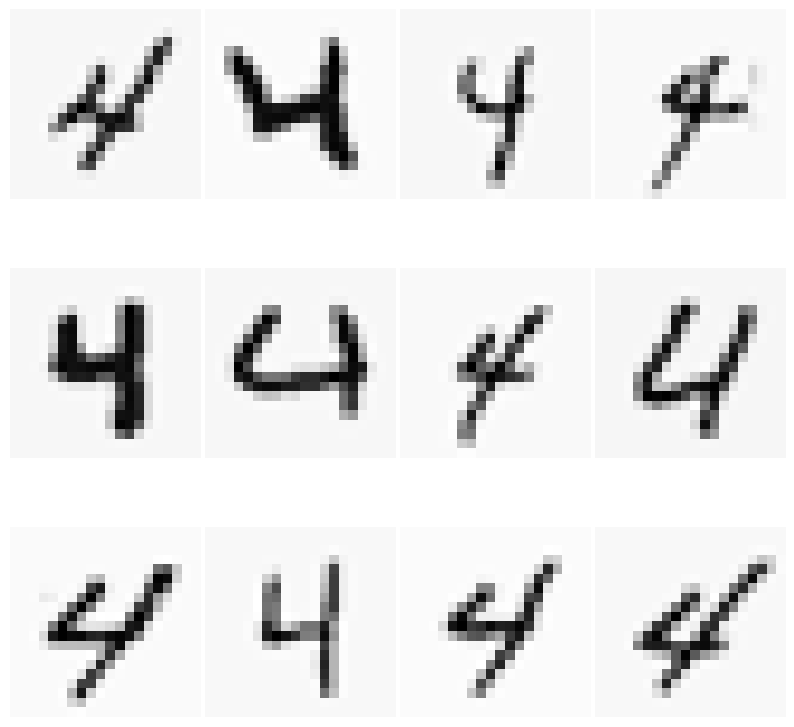

In [ ]:
print(X.shape)
pred = predictOneVsAll(all_theta, X)
print('Precision del conjuto de entrenamiento: {:.2f}%'.format(np.mean(pred == y) * 100))
XPrueba = X[2001:2013, :].copy()
print(XPrueba.shape)
#print(np.ones((1)))
#print(XPrueba)
#p = np.zeros(1)
XPrueba = np.concatenate([np.ones((12, 1)), XPrueba], axis=1)
print(XPrueba.shape)
p = np.argmax(sigmoid(XPrueba.dot(all_theta.T)), axis = 1)
print(p)

displayData(X[2001:2013, :])